In [1]:
import discretize
import numpy as np
from matplotlib import pyplot as plt
import SimPEG as simpeg
import geoana
import scipy.sparse as sp

import polarizability_model as pm

In [2]:
core_domain = 3 # meters
dx = 0.1
nc = int(core_domain / dx) + 1
npad = 2
pf = 1.3
hx = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
hy = [(dx, npad, -pf), (dx, nc), (dx, npad, pf)]
mesh = discretize.TensorMesh([hx, hy], origin="CC")

In [3]:
locations = np.hstack([mesh.gridCC, np.zeros((mesh.nC, 1))])

### Start with a simple example
- uniform inducing field in x, y, z
- grid of receivers in the core domain

In [122]:
rx_x = np.linspace(-core_domain/2, core_domain/2, 20)
rx_y = rx_x
rx_z = np.r_[0.25]

rx_locs = discretize.utils.ndgrid([rx_x, rx_y, rx_z])

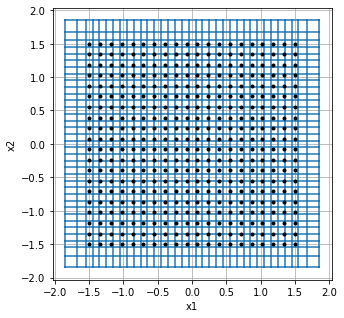

In [123]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

mesh.plot_grid(ax=ax)
ax.plot(rx_locs[:, 0], rx_locs[:, 1], 'k.')

In [124]:
receiver = pm.MagneticFluxDensityReceiver(rx_locs, components=["x", "y", "z"])
nrx = rx_locs.shape[0]

In [125]:
src_list = [
    pm.MagneticUniformSource([receiver], orientation) for orientation in ["x", "y", "z"]
]               

In [126]:
survey = pm.Survey(src_list)

In [127]:
sim = pm.SimulationPolarizabilityModel(locations, survey)

In [128]:
mtrue = np.zeros_like(locations)

x_target = np.r_[-0.25, 0.25]
y_target = np.r_[-0.25, 0.25]
m_target = np.r_[1, 1, 1]

bounding_box = (
    (locations[:, 0] > x_target.min()) &
    (locations[:, 0] < x_target.max()) &
    (locations[:, 1] > y_target.min()) &
    (locations[:, 1] < y_target.max()) 
)
for i, m in enumerate(m_target): 
    mtrue[bounding_box, i] = m

mtrue = mtrue.flatten() #discretize.utils.mkvc(mtrue)

(<matplotlib.collections.QuadMesh at 0x7feb0d8353d0>,)

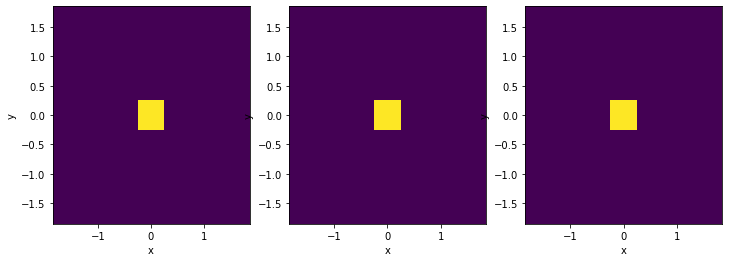

In [129]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
mesh.plot_image(mtrue[::3], ax=ax[0])
mesh.plot_image(mtrue[1::3], ax=ax[1])
mesh.plot_image(mtrue[2::3], ax=ax[2])

In [130]:
dtrue = sim.dpred(mtrue.flatten())
# data_true = simpeg.Data(survey, dtrue)

In [131]:
dtrue.shape

(3600,)

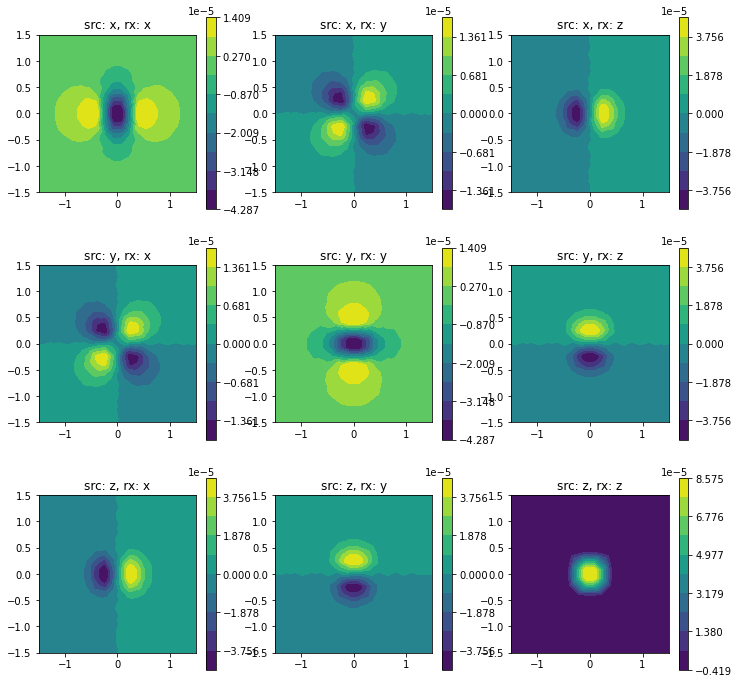

In [132]:
# plot the data

fig, ax = plt.subplots(3,3, figsize=(12, 12))

for i, src in enumerate(src_list):
    dipole = geoana.em.static.MagneticDipoleWholeSpace(location=np.r_[0, 0, 0], orientation=src.orientation)
    for j, comp in enumerate(["x", "y", "z"]): 
        dana = dipole.magnetic_flux_density(rx_locs)
        plt.colorbar(simpeg.utils.plot2Ddata(rx_locs[:,:2], dtrue[i*3*nrx:(i+1)*3*nrx][j::3], ax=ax[i, j])[0], ax=ax[i, j])
        ax[i, j].set_title(f"src: {src.orientation}, rx: {comp}")

In [133]:
# try a simple inversion 
import pydiso
from pymatsolver import Pardiso as Solver

In [143]:
noise_floor = 1e-6

G = np.vstack(sim.G)
Wd = (1./noise_floor) * np.eye(survey.nD)
WdG = Wd @ G
WdG2 = WdG.T @ WdG 
rhs = WdG.T @ Wd @ dtrue

In [170]:
beta = 1
A =  WdG2 + beta * np.eye(locations.shape[0]*3)

In [171]:
%%time
Ainv = Solver(sp.csr_matrix(A))
mrec = Ainv * rhs

CPU times: user 4.15 s, sys: 511 ms, total: 4.66 s
Wall time: 2.9 s


In [172]:
r = 1./noise_floor*(G@mrec-dtrue)
print(np.inner(r,r), survey.nD)

140671.78698359802 3600


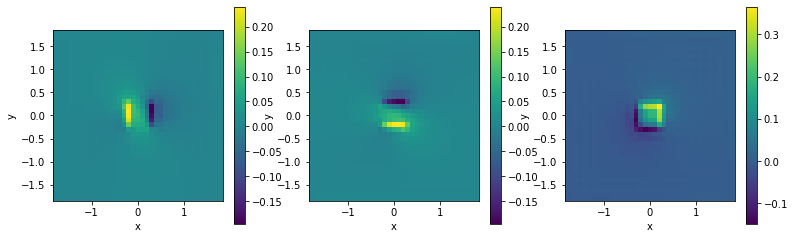

In [173]:
fig, ax = plt.subplots(1, 3, figsize=(13, 4))

for i, a in enumerate(ax): 
    plt.colorbar(mesh.plot_image(mrec[i::3], ax=a)[0], ax=a)
    a.set_aspect(1)
    

In [175]:
np.random.randn(10)

array([-1.19484394, -0.5130738 , -0.4876098 , -0.06605983, -1.15476492,
        0.61743563,  0.08276789, -0.30321311,  0.85858594, -0.82511505])